# Find shake cues in ACC measurements, without audio

Notebook to extract shaker table hits from audio recordings to correct for sensor clock offsets and drift. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import mir_eval.sonify


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
pip show librosa | grep Version

Version: 0.10.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show numpy | grep Version

Version: 1.25.2
Note: you may need to restart the kernel to use updated packages.


In [45]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [190]:
def local_max_ax(cue,cue_delay,thresh = 0.99):
    rms_sf = 256
    times = cue.index/rms_sf #(cue['dev_dTime']-cue.loc[0,'dev_dTime']).dt.total_seconds()
    cue_df = pd.DataFrame(index = times) # +cue_delay
    cue_df['rms'] = cue.values
    cue_df['peaks'] = 0
    a = cue_df['rms'].copy()
    a[a< a.quantile(thresh)] = 0
    peaks =pd.Series(sp.signal.find_peaks(a)[0])#, height = 300, threshold = None, distance=10

    j = 0
    while j <len(peaks):
        seg = peaks.loc[(peaks-peaks[j]).abs()<(rms_sf/2)].copy()
        if len(seg)>1:
            j = seg.index[-1]
            peak_j = a.iloc[seg.values].idxmax()
        else:
            peak_j = a.index[peaks[j]]
        cue_df.loc[peak_j,'peaks'] = 1
        j+=1

    return cue_df

def local_max_max(cue,cue_delay,thresh = 0.99):
    rms =librosa.feature.rms(y=cue, frame_length=256, hop_length=64, center=True, pad_mode='constant')
    times = librosa.times_like(rms,sr = sr, hop_length=64)
    rms_sf = int(sr/64)
    cue_df = pd.DataFrame(index = times+cue_delay)
    cue_df['rms'] = rms[0]
    cue_df['peaks'] = 0
    a = cue_df['rms'].copy()
    a[a< a.quantile(thresh)] = 0
    peaks =pd.Series(sp.signal.find_peaks(a)[0])#, height = 300, threshold = None, distance=10

    j = 0
    while j <len(peaks):
        seg = peaks.loc[(peaks-peaks[j]).abs()<(rms_sf/2)].copy()
        if len(seg)>1:
            j = seg.index[-1]
            peak_j = a.iloc[seg.values].idxmax()
        else:
            peak_j = a.index[peaks[j]]
        cue_df.loc[peak_j,'peaks'] = 1
        j+=1

    return cue_df

In [35]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

# monday March 4th, 2023, need both from signal (alos synch 1 audio)

In [37]:
data_dir='/Volumes/SeagateHub/BiC2024/20240304/Equivital/Extracted/' 
acc_file =data_dir+'BR602/FASTACC-BR602-5022184-24030400_0.CSV'#FASTACC-LS406-5023926-24030400_0
# y, sr = librosa.load(audio_file)
# file1_len = len(y)
V = pd.read_csv(acc_file,skipinitialspace=True)
sr = 256
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)


In [182]:
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-04 07:49:39.007,0.0
1,2024-03-04 07:49:39.011,0.0
2,2024-03-04 07:49:39.015,0.0
3,2024-03-04 07:49:39.019,0.0
4,2024-03-04 07:49:39.023,0.0
5,2024-03-04 07:49:39.027,0.0


In [184]:
synch_times = {}
# 285
synch_start= sync_start = pd.to_datetime('2024-03-04 07:51:38.000+0000').tz_localize(None) 
#pd.to_datetime('2024-03-04 07:52:08.000+0000')
synch_times['cue1_20240304'] = synch_start +pd.to_timedelta(285.7628,unit='s')

In [193]:
synch_times['cue1_20240304']

Timestamp('2024-03-04 07:56:23.762800')

2560


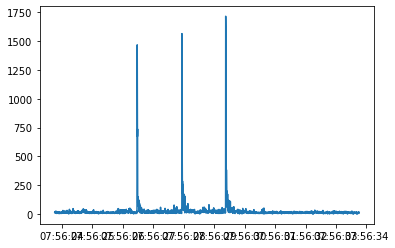

In [186]:
c = 'cue1_20240304'
shift = 285.76281179138317 # 255 # 
dt_0 = synch_start+pd.to_timedelta(shift,unit='s')-pd.to_timedelta(0,unit='s')
dt_1 = synch_start+pd.to_timedelta(shift,unit='s')+pd.to_timedelta(10,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [187]:
ACC_ex

,dev_dTime,signal
103625,2024-03-04 07:56:23.765,13.638182
103626,2024-03-04 07:56:23.769,12.369317
103627,2024-03-04 07:56:23.773,7.000000
103628,2024-03-04 07:56:23.777,7.615773
103629,2024-03-04 07:56:23.781,21.540659
...,...,...
106180,2024-03-04 07:56:33.746,4.000000
106181,2024-03-04 07:56:33.749,5.656854
106182,2024-03-04 07:56:33.753,8.944272
106183,2024-03-04 07:56:33.757,9.000000


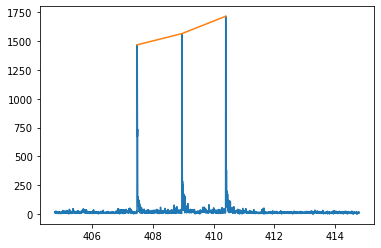

Index([nan, 1.46875, 1.4375], dtype='float64')

In [194]:
cue_df = local_max_ax(ACC_ex['signal'],np.round(0,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.index[cue_df['peaks']==1].diff() # [nan, 1.4686621315192951, 1.4396371882086214]

In [197]:
cue_df.index[cue_df['peaks']==1][0]

407.4921875

In [195]:
cue_df

,rms,peaks
404.785156,13.638182,0
404.789062,12.369317,0
404.792969,7.000000,0
404.796875,7.615773,0
404.800781,21.540659,0
...,...,...
414.765625,4.000000,0
414.769531,5.656854,0
414.773438,8.944272,0
414.777344,9.000000,0


In [198]:
cue_df['DateTime'] = synch_times['cue1_20240304'] + pd.to_timedelta(cue_df.index-cue_df.index[cue_df['peaks']==1][0],unit='s')
cue_df

,rms,peaks,DateTime
404.785156,13.638182,0,2024-03-04 07:56:21.055768750
404.789062,12.369317,0,2024-03-04 07:56:21.059675000
404.792969,7.000000,0,2024-03-04 07:56:21.063581250
404.796875,7.615773,0,2024-03-04 07:56:21.067487500
404.800781,21.540659,0,2024-03-04 07:56:21.071393750
...,...,...,...
414.765625,4.000000,0,2024-03-04 07:56:31.036237500
414.769531,5.656854,0,2024-03-04 07:56:31.040143750
414.773438,8.944272,0,2024-03-04 07:56:31.044050000
414.777344,9.000000,0,2024-03-04 07:56:31.047956250


In [199]:

cue_df.to_csv('./outfiles/cue1_acc_20240304.csv')

In [95]:
ACC_ex['signal']

,dev_dTime,signal
16380,2024-03-04 07:52:03.003,15.524175
16381,2024-03-04 07:52:03.007,15.779734
16382,2024-03-04 07:52:03.011,9.797959
16383,2024-03-04 07:52:03.015,8.062258
16384,2024-03-04 07:52:03.019,21.563859
...,...,...
20215,2024-03-04 07:52:17.984,5.656854
20216,2024-03-04 07:52:17.988,8.944272
20217,2024-03-04 07:52:17.992,12.000000
20218,2024-03-04 07:52:17.995,17.435596


In [200]:
synch_times['cue2_20240304'] = pd.to_datetime('2024-03-04 14:25:45.200+0000').tz_localize(None) 
# sync_end = pd.to_datetime('2024-03-04 14:25:45.000+0000') # 06:33:45 13:00


4096


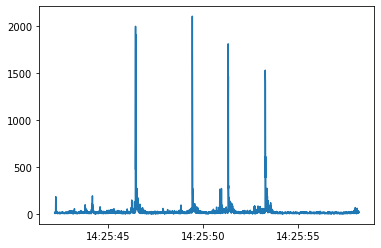

In [201]:
c = 'cue2_20240304'
dt_0 = synch_times[c]-pd.to_timedelta(3,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(13,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

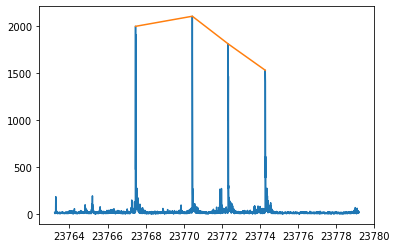

Index([nan, 2.984375, 1.8828125, 1.94921875], dtype='float64')

In [202]:
cue_df = local_max_ax(ACC_ex['signal'],np.round(0,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.index[cue_df['peaks']==1].diff() # [nan, 1.4686621315192951, 1.4396371882086214]

In [203]:
cue_df

,rms,peaks
23763.222656,14.966630,0
23763.226562,5.656854,0
23763.230469,8.944272,0
23763.234375,8.000000,0
23763.238281,17.464249,0
...,...,...
23779.203125,13.892444,0
23779.207031,16.278821,0
23779.210938,23.323808,0
23779.214844,23.664319,0


In [204]:
cue_df['DateTime'] = synch_times['cue2_20240304'] + pd.to_timedelta(cue_df.index-cue_df.index[cue_df['peaks']==1][0],unit='s')
cue_df

,rms,peaks,DateTime
23763.222656,14.966630,0,2024-03-04 14:25:40.950000000
23763.226562,5.656854,0,2024-03-04 14:25:40.953906250
23763.230469,8.944272,0,2024-03-04 14:25:40.957812500
23763.234375,8.000000,0,2024-03-04 14:25:40.961718750
23763.238281,17.464249,0,2024-03-04 14:25:40.965625000
...,...,...,...
23779.203125,13.892444,0,2024-03-04 14:25:56.930468750
23779.207031,16.278821,0,2024-03-04 14:25:56.934375000
23779.210938,23.323808,0,2024-03-04 14:25:56.938281250
23779.214844,23.664319,0,2024-03-04 14:25:56.942187500


In [205]:
cue_df.to_csv('./outfiles/cue2_acc_20240304.csv')

# Not Synch cues in audio for Wednesday

In [208]:
data_dir='/Volumes/SeagateHub/BiC2024/20240306/Equivital/Extracted SEM Data/' 
acc_file =data_dir+'BR609/FASTACC-BR609-5022222-24030600.CSV'#FASTACC-LS406-5023926-24030400_0
# y, sr = librosa.load(audio_file)
# file1_len = len(y)
V = pd.read_csv(acc_file,skipinitialspace=True)
sr = 256
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)


In [209]:
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-06 07:04:59.007,0.0
1,2024-03-06 07:04:59.011,0.0
2,2024-03-06 07:04:59.015,0.0
3,2024-03-06 07:04:59.019,0.0
4,2024-03-06 07:04:59.023,0.0
5,2024-03-06 07:04:59.027,0.0


In [234]:
synch_times = {}
# 285
synch_start= sync_start = pd.to_datetime('2024-03-06 07:12:00.000+0000').tz_localize(None) 
#pd.to_datetime('2024-03-04 07:52:08.000+0000')
synch_times['cue1_20240306'] = synch_start +pd.to_timedelta(8,unit='s')

2304


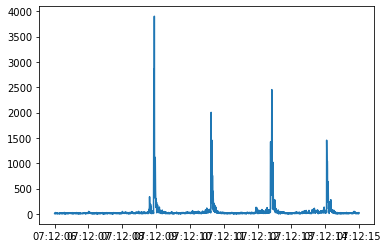

In [237]:
c = 'cue1_20240306'
shift = 0 # 255 # 
dt_0 = synch_times['cue1_20240306']+pd.to_timedelta(shift,unit='s')-pd.to_timedelta(2,unit='s')
dt_1 = synch_times['cue1_20240306']+pd.to_timedelta(shift,unit='s')+pd.to_timedelta(7,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

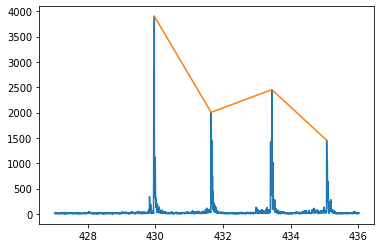

Index([nan, 1.6796875, 1.79296875, 1.62109375], dtype='float64')

In [238]:
cue_df = local_max_ax(ACC_ex['signal'],np.round(0,3))
cue_df#.sum()
cue_df['rms'].plot()
cue_df.loc[cue_df['peaks']==1,'rms'].plot()
plt.show()
cue_df.index[cue_df['peaks']==1].diff() # [nan, 1.4686621315192951, 1.4396371882086214]

In [242]:
cue_df['DateTime'] = synch_times['cue1_20240306'] + pd.to_timedelta(cue_df.index-cue_df.index[cue_df['peaks']==1][0],unit='s')
cue_df

,rms,peaks,DateTime
427.023438,6.928203,0,2024-03-06 07:12:05.054687500
427.027344,5.656854,0,2024-03-06 07:12:05.058593750
427.031250,12.000000,0,2024-03-06 07:12:05.062500000
427.035156,8.944272,0,2024-03-06 07:12:05.066406250
427.039062,4.000000,0,2024-03-06 07:12:05.070312500
...,...,...,...
436.003906,13.266499,0,2024-03-06 07:12:14.035156250
436.007812,4.000000,0,2024-03-06 07:12:14.039062500
436.011719,8.000000,0,2024-03-06 07:12:14.042968750
436.015625,20.808652,0,2024-03-06 07:12:14.046875000


In [243]:
cue_df.to_csv('./outfiles/cue1_acc_20240306.csv')

No apparent recorded second cue for monday. Maybe the spider got shut off by accident.

In [ ]:
# Sync1 at X tim?
# C1 tuning ?
# C2 tuning ?